In [1]:
import sys
import numpy as np
from timeit import default_timer as timer

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import colorsys

In [3]:
def load_pieces(filename):
    pieces = []
    with open(filename, 'r') as infile:
        n_pieces = int(infile.readline().rstrip())
        for piece_idndex in range(n_pieces):
            newline = infile.readline()
            while newline.startswith('#'):
                newline = infile.readline()
            y, x = [int(s) for s in newline.rstrip().split(' ')]
            piece = []
            for i in range(y):
                row = [int(s) for s in infile.readline().rstrip().split(' ')]
                piece.append(row)
            pieces.append(np.array(piece, dtype=np.int32))
    return pieces

In [5]:
def color_pieces(pieces):
    colored_pieces = [(i+1) * p for i, p in enumerate(pieces)]
    colors = [(0, 0, 0)]
    mult = (5**0.5 + 1) / 2
    h = np.random.random()
    color = colorsys.hsv_to_rgb(h, 0.5, 0.95)
    colors.append(color)
    while len(colors) <= len(pieces):
        h += mult
        h %= 1
        color = colorsys.hsv_to_rgb(h, 0.5, 0.95)
        colors.append(color)
    return colored_pieces, colors

In [6]:
def area(piece):
    return piece.astype(np.bool).sum()

def rotate(piece, change):
    change = change % 4
    if change == 0:
        return piece
    elif change == 1:
        return np.rot90(piece)
    elif change == 2:
        return np.rot90(piece, 2)
    elif change == 3:
        return np.rot90(piece, axes=(1, 0))

def test_piece_location(field, piece, row, column, place=False):
    if piece.shape[0] + row > field.shape[0]:
        return False
    if piece.shape[1] + column > field.shape[1]:
        return False
    field_slice = field[
        row: row + piece.shape[0],
        column: column + piece.shape[1]
    ]
    # print(field_slice * piece)
    result = ~np.any(field_slice * piece)
    if result and place:
        field_slice += piece
    return result

def greedy_place_piece(field, piece):
    for row in range(field.shape[0] - piece.shape[0] + 1):
        for column in range(field.shape[1] - piece.shape[1] + 1):
            if test_piece_location(field, piece, row, column, place=True):
                return True
    return False

In [7]:
class SimpleGA(object):
    
    def __init__(self, 
                 shape, 
                 pieces, 
                 pop_size,
                 n_offsprings,
                 p_mutation=0.03,
                 n_generations=1000,
                 crossover='cycle',
                 color_map=None,
                 picture_step=10,
                 survivors=2,
                 retirement_policy='keep'
                ):
        self.shape = shape
        self.pieces = pieces
        self.pop_size = pop_size
        self.population, self.fitnesses, self.matrices = self.gen_init_population(len(pieces), pop_size)
        self.n_offsprings = n_offsprings
        self.p_mutation = p_mutation
        self.n_generations = n_generations
        self.color_map = color_map
        self.picture_step = picture_step
        crossover_methods = {
            'order': self.order_crossover,
            'cycle': self.cycle_crossover
        }
        if crossover not in crossover_methods:
            raise ValueError("unsupported crossover method")
        fittest_selection = {
            'keep': self.select_fittest_with_merge,
            'quota': self.select_fittest_with_quota
        }
        if retirement_policy not in fittest_selection:
            raise ValueError("unknown retirement policy")
        self.select_fittest = fittest_selection[retirement_policy]
        self.crossover = crossover_methods[crossover]
        self.survivors = survivors
    
    def gen_init_population(self, n_pieces, pop_size):
        population = []
        fitnesses = []
        matrices = []
        for i in range(pop_size):
            individual = np.array([
                np.random.permutation(n_pieces),
                np.random.randint(0, 4, n_pieces)
            ])
            population.append(individual)
            fitness, field = self.greedy_placement(individual)
            fitnesses.append(fitness)
            matrices.append(field)
        return population, fitnesses, matrices
    
    def order_crossover(self, parent_1, parent_2):
        copy_begin, copy_end = np.random.choice(parent_1.shape[1], size=2, replace=False)
        if copy_end < copy_begin:
            copy_begin, copy_end = copy_end, copy_begin
        child_1 = -np.ones_like(parent_1)
        child_2 = -np.ones_like(parent_1)
        child_1[:, copy_begin:copy_end + 1] = parent_1[:, copy_begin:copy_end + 1]
        child_2[:, copy_begin:copy_end + 1] = parent_2[:, copy_begin:copy_end + 1]
        copied_indexes_1 = set(parent_1[0, copy_begin:copy_end + 1])
        copied_indexes_2 = set(parent_2[0, copy_begin:copy_end + 1])
        self._copy_remaining_genes(parent_2, child_1, copied_indexes_1, copy_begin, copy_end)
        self._copy_remaining_genes(parent_1, child_2, copied_indexes_2, copy_begin, copy_end)
        return child_1, child_2
        
    def _copy_remaining_genes(self, parent, child, used_indexes, copy_begin, copy_end):
        child_index = 0
        # print(copy_begin, copy_end)
        # print(used_indexes)
        for parent_index in range(parent.shape[1]):
            if copy_begin <= child_index <= copy_end:
                child_index += copy_end - copy_begin + 1
            if parent[0, parent_index] not in used_indexes:
                child[:, child_index] = parent[:, parent_index]
                child_index += 1
        return None
    
    def cycle_crossover(self, parent_1, parent_2):
        parent_1_inverse = np.argsort(parent_1[0])
        mask = -np.ones_like(parent_1[0])
        cycle_index = 0
        for index in range(parent_1.shape[1]):
            if mask[index] < 0:
                cycle_start = index
                next_index = parent_1_inverse[parent_2[0, cycle_start]]
                mask[next_index] = cycle_index
                while next_index != cycle_start:
                    next_index = parent_1_inverse[parent_2[0, next_index]]
                    mask[next_index] = cycle_index
                cycle_index += 1
        child_1 = -np.ones_like(parent_1)
        child_2 = -np.ones_like(parent_1)
        bool_mask = ~(mask % 2).astype(np.bool)
        child_1[:, bool_mask] = parent_1[:, bool_mask]
        child_1[:, ~bool_mask] = parent_2[:, ~bool_mask]
        child_2[:, bool_mask] = parent_2[:, bool_mask]
        child_2[:, ~bool_mask] = parent_1[:, ~bool_mask]
        return child_1, child_2
    
    def mutate(self, individual):
        # swaping two genes
        if np.random.random() < self.p_mutation:
            x, y = np.random.choice(individual.shape[1], size=2, replace=False)
            tmp = individual[:, x].copy()
            individual[:, x] = individual[:, y]
            individual[:, y] = tmp
        # randomly changing rotations
        else:
            mask = np.random.random(individual.shape[1]) < self.p_mutation
            individual[1, mask] = np.random.randint(0, 4, np.sum(mask))
        return individual
    
    def greedy_placement(self, individual):
        field = np.zeros(self.shape, dtype=np.int32)
        covered_area = 0
        for piece_index, rotation in individual.T:
            rotated_piece = rotate(self.pieces[piece_index], rotation)
            if not greedy_place_piece(field, rotated_piece):
                break
            else:
                covered_area += area(rotated_piece)
        return covered_area, field
    
    def select_parents(self, fitnesses=None):
        if fitnesses is None:
            fitnesses = self.fitnesses
        total_fitness = np.sum(fitnesses)
        parent_index_1, parent_index_2 = np.random.choice(
            len(self.population), 
            size=2, 
            replace=False, 
            p=fitnesses / total_fitness
        )
        return parent_index_1, parent_index_2
        
    def generate_offsprings(self):
        offsprings = []
        offsprings_fitness = []
        offspring_matrices = []
        while len(offsprings) < self.n_offsprings:
            parent_index_1, parent_index_2 = self.select_parents()
            children = self.crossover(
                self.population[parent_index_1],
                self.population[parent_index_2],
            )
            children = [self.mutate(child) for child in children]
            offsprings += children
            for child in children:
                fitness, matrix = self.greedy_placement(child)
                offsprings_fitness.append(fitness)
                offspring_matrices.append(matrix)
        return offsprings, offsprings_fitness, offspring_matrices
    
    def select_fittest_with_merge(self, offsprings, offsprings_fitness, offspring_matrices):
        self.population += offsprings
        self.fitnesses += offsprings_fitness
        self.matrices += offspring_matrices
        top_indexes = np.argsort(self.fitnesses)[::-1][:self.pop_size]
        self.population = [self.population[i] for i in top_indexes]
        self.fitnesses = [self.fitnesses[i] for i in top_indexes]
        self.matrices = [self.matrices[i] for i in top_indexes]
        self.best_index = 0
    
    def select_fittest_with_quota(self, offsprings, offsprings_fitness, offspring_matrices):
        old_top_indexes = np.argsort(self.fitnesses)[::-1][:self.survivors]
        new_top_indexes = np.argsort(offsprings_fitness)[::-1][:self.pop_size - self.survivors]
       
        self.population = [self.population[i] for i in old_top_indexes] + \
            [offsprings[i] for i in new_top_indexes]
        self.fitnesses = [self.fitnesses[i] for i in old_top_indexes] + \
            [offsprings_fitness[i] for i in new_top_indexes]
        self.matrices = [self.matrices[i] for i in old_top_indexes] + \
            [offspring_matrices[i] for i in new_top_indexes]
        self.best_index = np.argmax(self.fitnesses)
    
    def run(self, generations=None):
        if generations is None:
            generations = self.n_generations
        for generation in range(1, generations):
            timeit_start = timer()
            offsprings, offsprings_fitness, offspring_matrices = self.generate_offsprings()
            self.select_fittest(offsprings, offsprings_fitness, offspring_matrices)
            timeit_end = timer()
            print("generation %s created in %0.3f seconds" % (generation, timeit_end - timeit_start))
            print("best result: %s, pop_size: %s" % (self.fitnesses[self.best_index], len(self.population)))
            if (self.color_map is not None and 
                (generation % self.picture_step == 0 or generation + 1 == generations)):
                draw_matrix(self.matrices[self.best_index], self.color_map, self.shape)
        

In [11]:
def draw_matrix(matrix, color_map, shape):
    fig1 = plt.figure(figsize=(20,10))
    ax1 = fig1.add_subplot(111, aspect='equal')
    for y, row in enumerate(matrix):
        for x, val in enumerate(row):
            ax1.add_patch(patches.Rectangle((x, y), 1, 1, color=color_map[val]))
    plt.xlim(0, shape[1])
    plt.ylim(0, shape[0])
    plt.show()

In [4]:
test_pieces = load_pieces('test_pieces.txt')

In [12]:
total_area = np.sum([area(p) for p in test_pieces])
print(total_area)

290


generation 1 created in 0.968 seconds
best result: 230, pop_size: 200
generation 2 created in 1.388 seconds
best result: 237, pop_size: 200
generation 3 created in 1.478 seconds
best result: 242, pop_size: 200
generation 4 created in 1.791 seconds
best result: 247, pop_size: 200
generation 5 created in 1.945 seconds
best result: 247, pop_size: 200
generation 6 created in 2.004 seconds
best result: 247, pop_size: 200
generation 7 created in 2.204 seconds
best result: 262, pop_size: 200
generation 8 created in 2.315 seconds
best result: 262, pop_size: 200
generation 9 created in 2.384 seconds
best result: 262, pop_size: 200
generation 10 created in 2.485 seconds
best result: 262, pop_size: 200


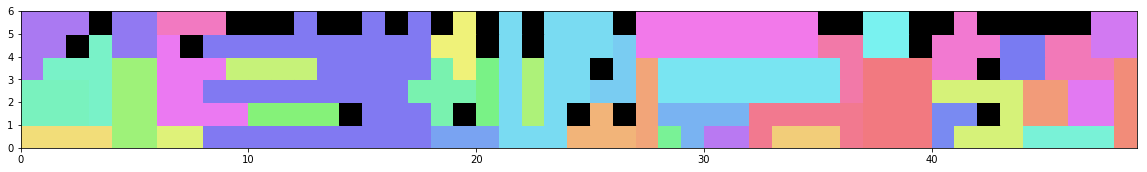

generation 11 created in 2.891 seconds
best result: 262, pop_size: 200
generation 12 created in 2.888 seconds
best result: 262, pop_size: 200
generation 13 created in 2.846 seconds
best result: 262, pop_size: 200
generation 14 created in 2.917 seconds
best result: 262, pop_size: 200
generation 15 created in 2.953 seconds
best result: 262, pop_size: 200
generation 16 created in 3.152 seconds
best result: 262, pop_size: 200
generation 17 created in 3.020 seconds
best result: 262, pop_size: 200
generation 18 created in 3.189 seconds
best result: 262, pop_size: 200
generation 19 created in 3.030 seconds
best result: 262, pop_size: 200
generation 20 created in 3.086 seconds
best result: 262, pop_size: 200


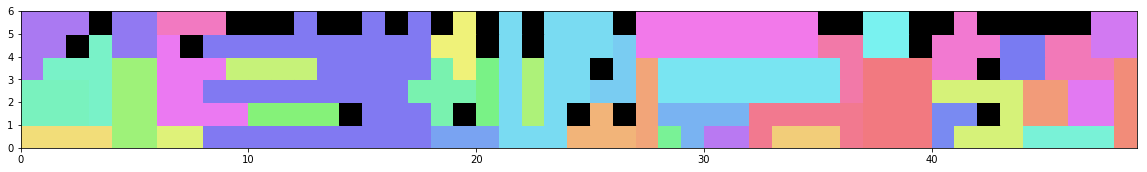

generation 21 created in 3.122 seconds
best result: 262, pop_size: 200
generation 22 created in 2.960 seconds
best result: 262, pop_size: 200
generation 23 created in 3.429 seconds
best result: 266, pop_size: 200
generation 24 created in 3.209 seconds
best result: 266, pop_size: 200
generation 25 created in 3.467 seconds
best result: 266, pop_size: 200
generation 26 created in 3.312 seconds
best result: 266, pop_size: 200
generation 27 created in 3.219 seconds
best result: 266, pop_size: 200
generation 28 created in 3.163 seconds
best result: 266, pop_size: 200
generation 29 created in 3.157 seconds
best result: 266, pop_size: 200
generation 30 created in 3.263 seconds
best result: 266, pop_size: 200


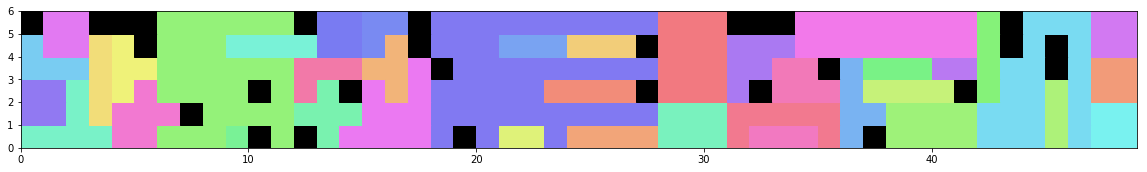

generation 31 created in 3.073 seconds
best result: 266, pop_size: 200
generation 32 created in 3.211 seconds
best result: 271, pop_size: 200
generation 33 created in 3.184 seconds
best result: 271, pop_size: 200
generation 34 created in 3.529 seconds
best result: 271, pop_size: 200
generation 35 created in 3.706 seconds
best result: 271, pop_size: 200
generation 36 created in 3.688 seconds
best result: 271, pop_size: 200
generation 37 created in 3.697 seconds
best result: 271, pop_size: 200
generation 38 created in 3.644 seconds
best result: 271, pop_size: 200
generation 39 created in 3.777 seconds
best result: 271, pop_size: 200
generation 40 created in 3.685 seconds
best result: 271, pop_size: 200


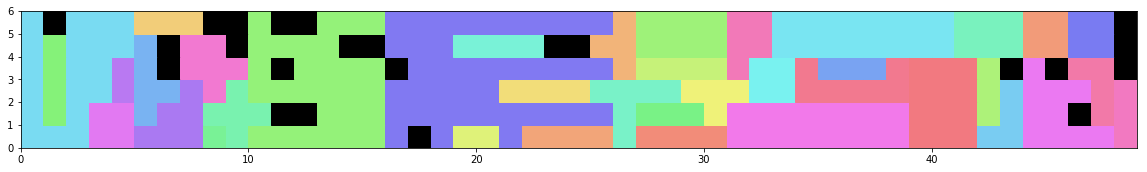

generation 41 created in 3.665 seconds
best result: 271, pop_size: 200
generation 42 created in 3.897 seconds
best result: 271, pop_size: 200
generation 43 created in 3.862 seconds
best result: 271, pop_size: 200
generation 44 created in 3.759 seconds
best result: 271, pop_size: 200
generation 45 created in 3.499 seconds
best result: 271, pop_size: 200
generation 46 created in 3.683 seconds
best result: 271, pop_size: 200
generation 47 created in 3.621 seconds
best result: 275, pop_size: 200
generation 48 created in 3.775 seconds
best result: 275, pop_size: 200
generation 49 created in 3.494 seconds
best result: 275, pop_size: 200
generation 50 created in 3.612 seconds
best result: 276, pop_size: 200


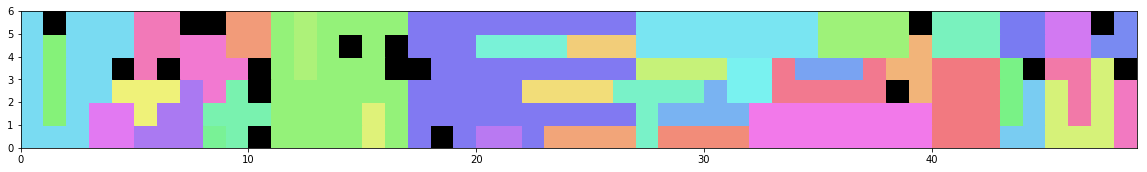

generation 51 created in 3.903 seconds
best result: 276, pop_size: 200
generation 52 created in 4.093 seconds
best result: 276, pop_size: 200
generation 53 created in 3.969 seconds
best result: 276, pop_size: 200
generation 54 created in 3.870 seconds
best result: 276, pop_size: 200
generation 55 created in 4.024 seconds
best result: 276, pop_size: 200
generation 56 created in 4.152 seconds
best result: 276, pop_size: 200
generation 57 created in 4.140 seconds
best result: 276, pop_size: 200
generation 58 created in 3.823 seconds
best result: 276, pop_size: 200
generation 59 created in 4.028 seconds
best result: 276, pop_size: 200
generation 60 created in 4.256 seconds
best result: 276, pop_size: 200


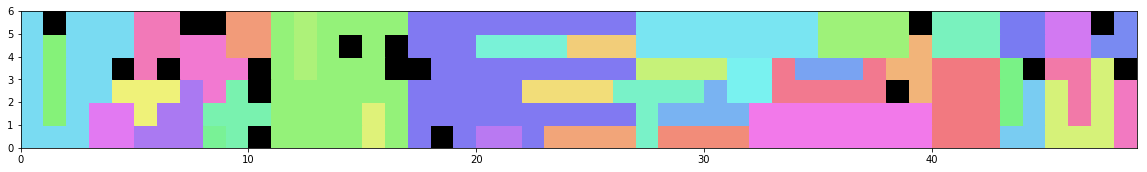

generation 61 created in 3.904 seconds
best result: 276, pop_size: 200
generation 62 created in 3.857 seconds
best result: 276, pop_size: 200
generation 63 created in 3.871 seconds
best result: 276, pop_size: 200
generation 64 created in 3.915 seconds
best result: 276, pop_size: 200
generation 65 created in 4.288 seconds
best result: 276, pop_size: 200
generation 66 created in 4.305 seconds
best result: 276, pop_size: 200
generation 67 created in 4.193 seconds
best result: 276, pop_size: 200
generation 68 created in 4.298 seconds
best result: 276, pop_size: 200
generation 69 created in 4.085 seconds
best result: 276, pop_size: 200
generation 70 created in 4.120 seconds
best result: 276, pop_size: 200


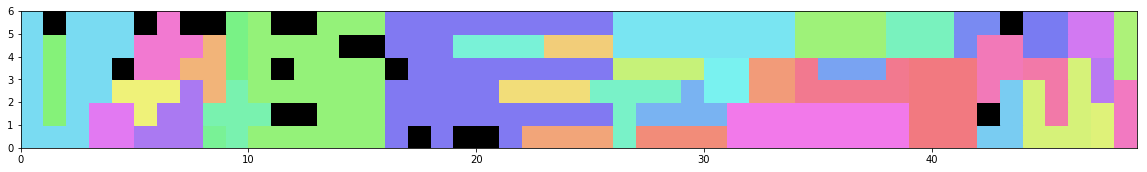

generation 71 created in 4.445 seconds
best result: 276, pop_size: 200
generation 72 created in 4.413 seconds
best result: 276, pop_size: 200
generation 73 created in 4.280 seconds
best result: 276, pop_size: 200
generation 74 created in 3.863 seconds
best result: 276, pop_size: 200
generation 75 created in 4.300 seconds
best result: 276, pop_size: 200
generation 76 created in 3.874 seconds
best result: 276, pop_size: 200
generation 77 created in 4.040 seconds
best result: 276, pop_size: 200
generation 78 created in 4.219 seconds
best result: 276, pop_size: 200
generation 79 created in 4.200 seconds
best result: 276, pop_size: 200
generation 80 created in 4.257 seconds
best result: 276, pop_size: 200


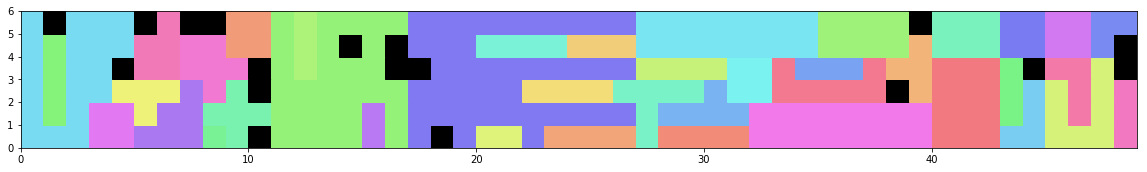

generation 81 created in 4.110 seconds
best result: 276, pop_size: 200
generation 82 created in 4.131 seconds
best result: 276, pop_size: 200
generation 83 created in 4.316 seconds
best result: 276, pop_size: 200
generation 84 created in 3.953 seconds
best result: 276, pop_size: 200
generation 85 created in 4.332 seconds
best result: 276, pop_size: 200
generation 86 created in 4.034 seconds
best result: 276, pop_size: 200
generation 87 created in 3.774 seconds
best result: 276, pop_size: 200
generation 88 created in 4.244 seconds
best result: 276, pop_size: 200
generation 89 created in 4.233 seconds
best result: 276, pop_size: 200
generation 90 created in 4.291 seconds
best result: 277, pop_size: 200


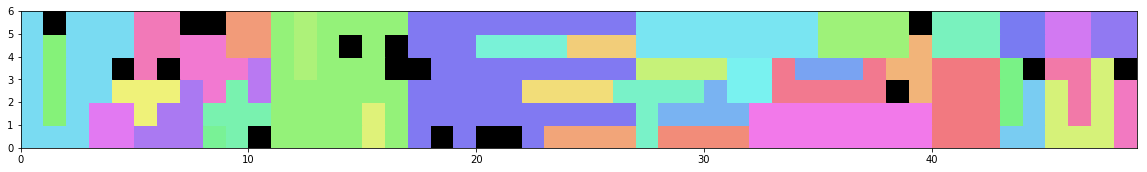

generation 91 created in 4.198 seconds
best result: 277, pop_size: 200
generation 92 created in 3.878 seconds
best result: 277, pop_size: 200
generation 93 created in 4.014 seconds
best result: 277, pop_size: 200
generation 94 created in 4.205 seconds
best result: 277, pop_size: 200
generation 95 created in 4.152 seconds
best result: 277, pop_size: 200
generation 96 created in 4.334 seconds
best result: 277, pop_size: 200
generation 97 created in 4.262 seconds
best result: 277, pop_size: 200
generation 98 created in 4.443 seconds
best result: 277, pop_size: 200
generation 99 created in 4.192 seconds
best result: 277, pop_size: 200


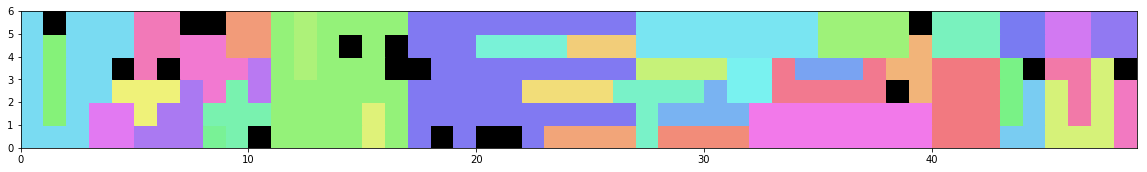

In [13]:
colored_pieces, color_map = color_pieces(test_pieces)
np.random.seed(1543)
ga = SimpleGA(
    [6, 49],
    colored_pieces,
    pop_size=200,
    n_offsprings=200,
    n_generations=100,
    color_map=color_map,
    crossover='cycle',
    retirement_policy='keep'
)
ga.run()

generation 1 created in 1.014 seconds
best result: 231, pop_size: 200
generation 2 created in 1.216 seconds
best result: 240, pop_size: 200
generation 3 created in 1.418 seconds
best result: 242, pop_size: 200
generation 4 created in 1.601 seconds
best result: 242, pop_size: 200
generation 5 created in 1.762 seconds
best result: 242, pop_size: 200
generation 6 created in 2.160 seconds
best result: 246, pop_size: 200
generation 7 created in 2.102 seconds
best result: 246, pop_size: 200
generation 8 created in 2.207 seconds
best result: 254, pop_size: 200
generation 9 created in 2.154 seconds
best result: 254, pop_size: 200
generation 10 created in 2.334 seconds
best result: 254, pop_size: 200


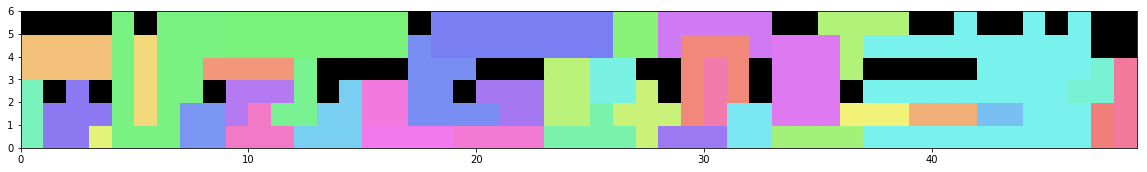

generation 11 created in 2.169 seconds
best result: 254, pop_size: 200
generation 12 created in 2.162 seconds
best result: 254, pop_size: 200
generation 13 created in 2.885 seconds
best result: 254, pop_size: 200
generation 14 created in 2.543 seconds
best result: 254, pop_size: 200
generation 15 created in 2.166 seconds
best result: 267, pop_size: 200
generation 16 created in 2.642 seconds
best result: 267, pop_size: 200
generation 17 created in 2.602 seconds
best result: 267, pop_size: 200
generation 18 created in 2.762 seconds
best result: 267, pop_size: 200
generation 19 created in 2.666 seconds
best result: 267, pop_size: 200
generation 20 created in 2.686 seconds
best result: 267, pop_size: 200


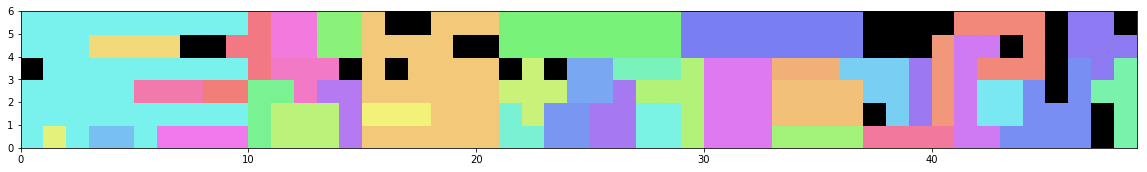

generation 21 created in 2.756 seconds
best result: 267, pop_size: 200
generation 22 created in 2.744 seconds
best result: 267, pop_size: 200
generation 23 created in 2.822 seconds
best result: 267, pop_size: 200
generation 24 created in 2.623 seconds
best result: 267, pop_size: 200
generation 25 created in 2.687 seconds
best result: 267, pop_size: 200
generation 26 created in 2.849 seconds
best result: 267, pop_size: 200
generation 27 created in 3.094 seconds
best result: 267, pop_size: 200
generation 28 created in 2.768 seconds
best result: 267, pop_size: 200
generation 29 created in 2.998 seconds
best result: 267, pop_size: 200
generation 30 created in 2.801 seconds
best result: 267, pop_size: 200


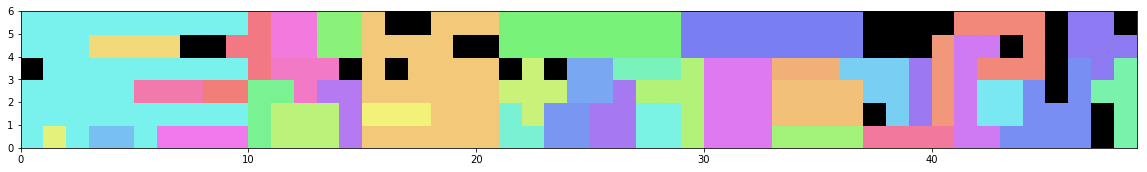

generation 31 created in 2.769 seconds
best result: 267, pop_size: 200
generation 32 created in 3.072 seconds
best result: 267, pop_size: 200
generation 33 created in 2.889 seconds
best result: 267, pop_size: 200
generation 34 created in 2.996 seconds
best result: 267, pop_size: 200
generation 35 created in 2.765 seconds
best result: 267, pop_size: 200
generation 36 created in 2.932 seconds
best result: 267, pop_size: 200
generation 37 created in 2.841 seconds
best result: 267, pop_size: 200
generation 38 created in 3.041 seconds
best result: 270, pop_size: 200
generation 39 created in 2.828 seconds
best result: 270, pop_size: 200
generation 40 created in 2.667 seconds
best result: 270, pop_size: 200


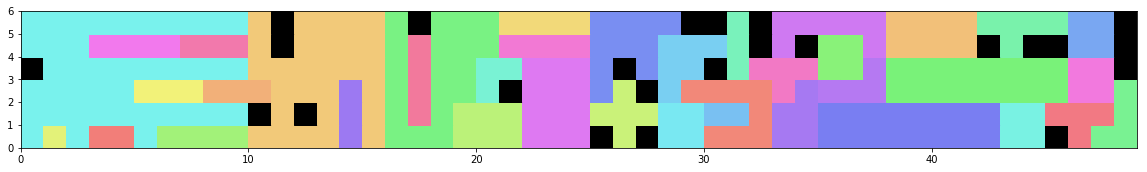

generation 41 created in 2.784 seconds
best result: 270, pop_size: 200
generation 42 created in 2.839 seconds
best result: 270, pop_size: 200
generation 43 created in 2.783 seconds
best result: 270, pop_size: 200
generation 44 created in 2.802 seconds
best result: 270, pop_size: 200
generation 45 created in 2.699 seconds
best result: 270, pop_size: 200
generation 46 created in 2.804 seconds
best result: 270, pop_size: 200
generation 47 created in 2.622 seconds
best result: 270, pop_size: 200
generation 48 created in 2.885 seconds
best result: 270, pop_size: 200
generation 49 created in 2.971 seconds
best result: 276, pop_size: 200
generation 50 created in 2.949 seconds
best result: 276, pop_size: 200


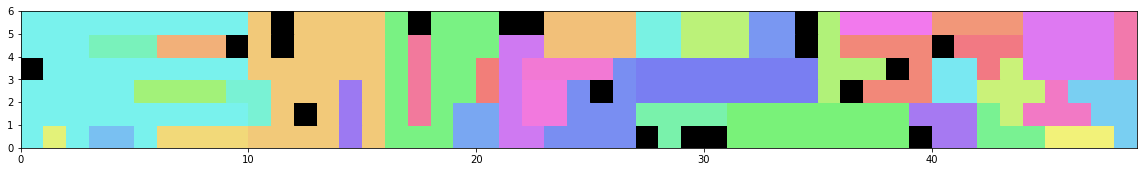

generation 51 created in 3.117 seconds
best result: 276, pop_size: 200
generation 52 created in 2.937 seconds
best result: 276, pop_size: 200
generation 53 created in 2.870 seconds
best result: 276, pop_size: 200
generation 54 created in 3.028 seconds
best result: 276, pop_size: 200
generation 55 created in 2.795 seconds
best result: 276, pop_size: 200
generation 56 created in 2.747 seconds
best result: 276, pop_size: 200
generation 57 created in 2.915 seconds
best result: 276, pop_size: 200
generation 58 created in 2.786 seconds
best result: 276, pop_size: 200
generation 59 created in 2.568 seconds
best result: 276, pop_size: 200
generation 60 created in 2.547 seconds
best result: 276, pop_size: 200


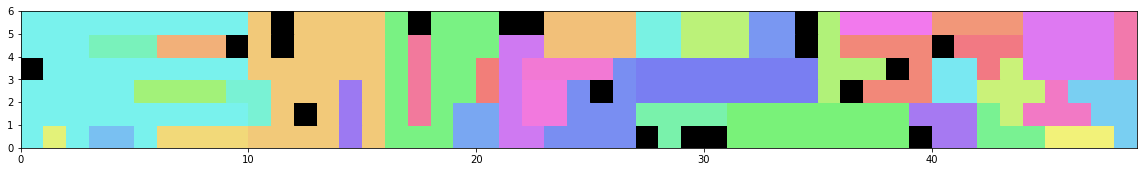

generation 61 created in 2.747 seconds
best result: 276, pop_size: 200
generation 62 created in 2.981 seconds
best result: 276, pop_size: 200
generation 63 created in 3.442 seconds
best result: 276, pop_size: 200
generation 64 created in 3.216 seconds
best result: 276, pop_size: 200
generation 65 created in 2.931 seconds
best result: 276, pop_size: 200
generation 66 created in 2.828 seconds
best result: 276, pop_size: 200
generation 67 created in 3.132 seconds
best result: 276, pop_size: 200
generation 68 created in 3.114 seconds
best result: 276, pop_size: 200
generation 69 created in 2.962 seconds
best result: 276, pop_size: 200
generation 70 created in 3.057 seconds
best result: 276, pop_size: 200


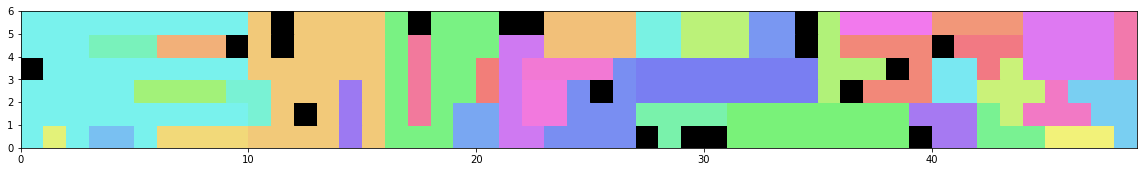

generation 71 created in 3.191 seconds
best result: 276, pop_size: 200
generation 72 created in 3.138 seconds
best result: 276, pop_size: 200
generation 73 created in 2.884 seconds
best result: 276, pop_size: 200
generation 74 created in 3.063 seconds
best result: 276, pop_size: 200
generation 75 created in 3.052 seconds
best result: 276, pop_size: 200
generation 76 created in 3.051 seconds
best result: 276, pop_size: 200
generation 77 created in 3.001 seconds
best result: 276, pop_size: 200
generation 78 created in 2.931 seconds
best result: 276, pop_size: 200
generation 79 created in 3.031 seconds
best result: 276, pop_size: 200
generation 80 created in 3.033 seconds
best result: 276, pop_size: 200


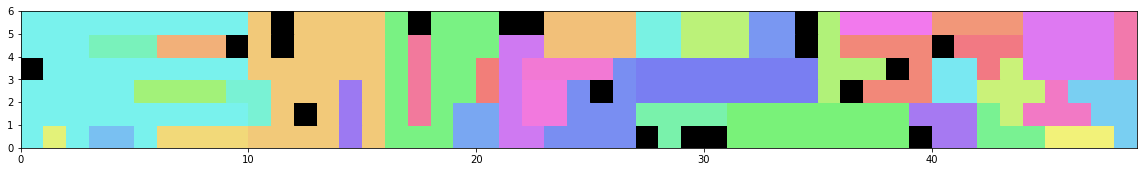

generation 81 created in 2.953 seconds
best result: 276, pop_size: 200
generation 82 created in 3.193 seconds
best result: 276, pop_size: 200
generation 83 created in 3.247 seconds
best result: 276, pop_size: 200
generation 84 created in 3.251 seconds
best result: 276, pop_size: 200
generation 85 created in 3.044 seconds
best result: 276, pop_size: 200
generation 86 created in 3.141 seconds
best result: 276, pop_size: 200
generation 87 created in 3.421 seconds
best result: 276, pop_size: 200
generation 88 created in 3.357 seconds
best result: 276, pop_size: 200
generation 89 created in 3.537 seconds
best result: 276, pop_size: 200
generation 90 created in 3.442 seconds
best result: 280, pop_size: 200


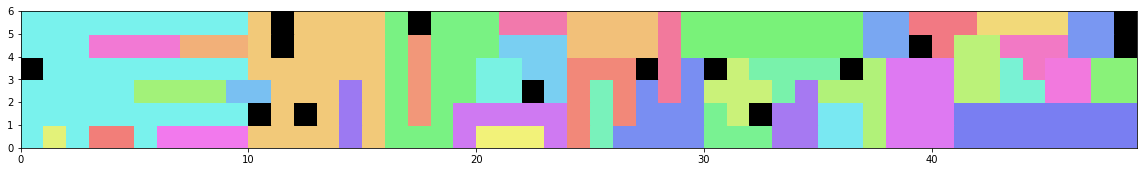

generation 91 created in 3.428 seconds
best result: 280, pop_size: 200
generation 92 created in 3.532 seconds
best result: 280, pop_size: 200
generation 93 created in 3.671 seconds
best result: 280, pop_size: 200
generation 94 created in 3.460 seconds
best result: 280, pop_size: 200
generation 95 created in 3.659 seconds
best result: 280, pop_size: 200
generation 96 created in 3.356 seconds
best result: 280, pop_size: 200
generation 97 created in 3.490 seconds
best result: 280, pop_size: 200
generation 98 created in 3.573 seconds
best result: 280, pop_size: 200
generation 99 created in 3.406 seconds
best result: 280, pop_size: 200


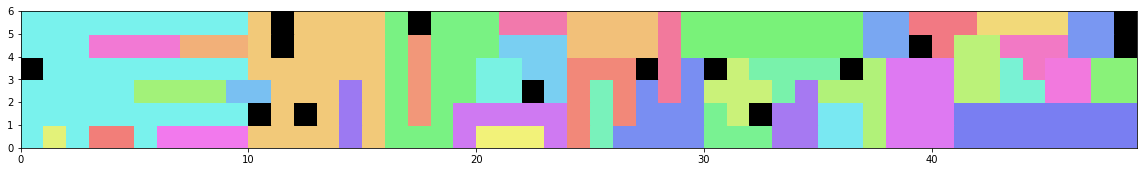

In [14]:
colored_pieces, color_map = color_pieces(test_pieces)
np.random.seed(1543)
ga = SimpleGA(
    [6, 49],
    colored_pieces,
    pop_size=200,
    n_offsprings=200,
    n_generations=100,
    color_map=color_map,
    crossover='order',
    retirement_policy='keep'
)
ga.run()